In [27]:
import os
import shutil
from dataclasses import dataclass, field
from math import exp

import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, random_split
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms.transforms import Compose
from tqdm import tqdm

In [28]:
@dataclass(frozen=True)
class Config:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    model_weights: str = "./model_weights"
    hra_net_name: str = "/model.pth"
    images_path: str = "./images"
    target_disease: str = "COVID-19"
    image_size: tuple = (300, 300)
    kernel_sizes: list = field(default_factory=lambda: [3, 5, 7])
    batch_size: int = 16



config = Config()

In [29]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)) -> None:
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img) -> Image.Image:
        img_np = np.array(img)
        if len(img_np.shape) == 3:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(
            clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size
        )
        img_clahe = clahe.apply(img_np)
        return Image.fromarray(img_clahe)

In [30]:
os.makedirs(config.images_path, exist_ok=True)
os.makedirs(config.model_weights, exist_ok=True)

In [31]:
transform: Compose = transforms.Compose(
    [
        CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
        transforms.Resize(config.image_size),
        transforms.ToTensor(),
    ]
)

In [32]:
class ResidualBlock(nn.Module):
    """
    Implements a **Residual Block**, the fundamental building block of ResNet.

    Mathematically, given an input $x$, the block learns a residual function $F(x)$.
    The output $y$ is computed as:
    $$ y = \sigma(F(x, \{W_i\}) + x) $$
    where $W_i$ represent the weights of the layers, and $\sigma$ is the activation function (ReLU/LeakyReLU).

    **Scientific Rationale:**
    Deep networks often suffer from the **degradation problem** and **vanishing gradients**.
    By introducing an **identity shortcut connection** (the $+x$ term), the gradient can flow directly
    through the network during backpropagation. This acts as a "gradient superhighway,"
    facilitating the optimization of very deep architectures.

    **Structure:**
    1. **Main Path ($F(x)$)**: Conv -> BN -> Activation -> Conv -> BN
    2. **Shortcut Path**: Identity mapping (or 1x1 Conv for dimension matching)
    3. **Addition**: Element-wise sum of Main and Shortcut paths.

    Args:
        in_channels (int): Number of input feature channels.
        out_channels (int): Number of output feature channels.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # The main path (F(x)): Convolution -> BN -> Activation -> Convolution -> BN
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        # The shortcut path (x):
        # If dimensions change, use 1x1 Conv to match sizes. Otherwise, pass identity.
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        # Result is F(x) + x, followed by the final activation
        return nn.functional.leaky_relu(self.main(x) + self.shortcut(x), 0.2)

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1791349947.py:7: SyntaxWarning: invalid escape sequence '\s'
  $$ y = \sigma(F(x, \{W_i\}) + x) $$


In [33]:
class ReadHeads(nn.Module):
    r"""
    Implements a Multi-Scale Feature Extraction module, conceptually similar to the **Inception** module.

    **Scientific Rationale:**
    Optimal kernel size varies depending on the size of the salient features in the image.
    Instead of committing to a single kernel size, this module applies multiple convolutions
    with different receptive fields ($k \in \{3, 5, 7\}$) in parallel.

    Mathematically, the output $Y$ is the concatenation of feature maps from different branches:
    $$ Y = \text{Concat}(\phi_3(X), \phi_5(X), \phi_7(X)) $$
    where $\phi_k$ represents the transformation (Conv + BN + Activation) with kernel size $k$.

    This allows the network to simultaneously capture:
    - **Local textures/details** (small kernels, e.g., 3x3)
    - **Global shape/context** (large kernels, e.g., 7x7)

    Args:
        in_channels (int): Number of input channels.
        kernel_sizes (list[int]): List of kernel sizes for parallel branches.
        feature_per_head (int): Number of filters for each branch.
    """

    def __init__(
        self,
        in_channels=3,
        kernel_sizes: list[int] = [3, 5, 7],
        feature_per_head: int = 64,
    ) -> None:
        super().__init__()
        self.read_heads = nn.ModuleList()
        for ks in kernel_sizes:
            self.read_heads.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        feature_per_head,
                        kernel_size=ks,
                        padding=(ks - 1) // 2,
                    ),
                    nn.BatchNorm2d(feature_per_head),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )

    def forward(self, x: Tensor) -> Tensor:
        return torch.cat([head(x) for head in self.read_heads], dim=1)

In [34]:
class Covid_Net(nn.Module):
    def __init__(
        self,
        kernel_sizes: list[int],
        number_of_classes: int,
        feature_per_head: int = 64,
    ) -> None:
        """
        **Covid_Net Architecture**

        A custom deep convolutional neural network optimized for medical image classification.

        **Architectural Design:**
        1.  **Multi-Scale Input Processing (ReadHeads)**:
            - Replaces standard initial convolutions with parallel multi-kernel extraction.
            - Ensures diverse feature representation from the raw input.
        2.  **Hierarchical Feature Learning**:
            - Uses a sequence of **Residual Blocks** interspersed with Downsampling layers.
            - Progressively reduces spatial resolution ($H, W$) while increasing semantic depth (Channels).
        3.  **Learning Bottleneck**:
            - A dense sequence of residual blocks at the lowest spatial resolution to process high-level interactions.
        4.  **Classification Head**:
            - Global Average Pooling (GAP) to obtain translation-invariant features.
            - Multi-Layer Perceptron (MLP) for final decision boundary.

        Args:
            kernel_sizes (list[int]): Kernels for the input reading heads.
            number_of_classes (int): Number of output classes (1 for binary).
            feature_per_head (int): Filters per head.
        """
        super().__init__()

        # 1. Multi-Scale Feature Extraction
        # Captures features at different scales (3x3, 5x5, 7x7) simultaneously
        self.read_heads = ReadHeads(
            in_channels=1, kernel_sizes=kernel_sizes, feature_per_head=feature_per_head
        )

        # Calculate total channels resulting from concatenating the heads
        # e.g., if 3 kernels and 64 features per head, channel_count = 192
        channel_count = feature_per_head * len(kernel_sizes)

        # 2. Downsampling Sequence
        # Processes features and reduces image size (H, W) using strided convolutions
        self.downsampling = nn.Sequential(
            ResidualBlock(channel_count, channel_count),
            nn.Conv2d(
                channel_count, channel_count, kernel_size=4, stride=2, padding=1
            ),  # Halves H, W
            ResidualBlock(channel_count, channel_count),
            nn.Conv2d(
                channel_count, channel_count, kernel_size=4, stride=2, padding=1
            ),  # Halves H, W
            ResidualBlock(channel_count, channel_count),
            nn.Conv2d(
                channel_count, channel_count, kernel_size=4, stride=2, padding=1
            ),  # Halves H, W
            ResidualBlock(channel_count, channel_count),
        )
        self.learning_bottleneck = nn.Sequential(
            ResidualBlock(channel_count, channel_count * 2),
            ResidualBlock(channel_count * 2, channel_count * 4),
            ResidualBlock(channel_count * 4, channel_count * 8),
        )
        # 3. Global Pooling
        # Converts spatial maps (Channels, H, W) into a vector (Channels)
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Forces output to be [B, Channels, 1, 1]
            nn.Flatten(),  # Flattens to [B, Channels]
        )

        # 4. Classifier
        # NOTE: I changed the input size from the hardcoded '1536' to 'channel_count'
        # so it matches the output of the read_heads/downsampling (e.g., 192).
        self.classifier = nn.Sequential(
            nn.Linear(channel_count * 8, 12288),  # Adjusted input dim
            nn.LeakyReLU(0.2),
            nn.Linear(12288, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, number_of_classes),
        )

    def forward(self, x):
        """
        Forward pass defining the data flow through the network.

        Args:
            x (Tensor): Input image batch of shape [Batch, 1, H, W]
        """

        # Step 1: Extract features using the Inception-like ReadHeads
        # Input: [B, 1, H, W] -> Output: [B, channel_count, H, W]
        x = self.read_heads(x)

        # Step 2: Pass through the Downsampling/Residual blocks
        # Reduces spatial dimensions while refining features
        # Output: [B, channel_count, H/8, W/8] (due to 3 strided convs)
        x = self.downsampling(x)

        x = self.learning_bottleneck(x)

        # Step 3: Global Average Pooling and Flattening
        # Aggregates spatial information into a single feature vector per image
        # Output: [B, channel_count]
        x = self.global_pool(x)

        # Step 4: Classification MLP
        # Maps features to class probabilities (logits)
        # Output: [B, number_of_classes]
        return self.classifier(x)

In [35]:
model = Covid_Net(config.kernel_sizes, 1)
model.to(config.device)

# Load existing weights if available
weights_path = config.model_weights + config.hra_net_name
if os.path.exists(weights_path):
    print(f"Loading existing model weights from {weights_path}")
    model.load_state_dict(torch.load(weights_path, map_location=config.device))
else:
    print("No existing weights found. Starting from scratch.")
summary(model, (1, *config.image_size))


Loading existing model weights from ./model_weights/model.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]             640
       BatchNorm2d-2         [-1, 64, 300, 300]             128
         LeakyReLU-3         [-1, 64, 300, 300]               0
            Conv2d-4         [-1, 64, 300, 300]           1,664
       BatchNorm2d-5         [-1, 64, 300, 300]             128
         LeakyReLU-6         [-1, 64, 300, 300]               0
            Conv2d-7         [-1, 64, 300, 300]           3,200
       BatchNorm2d-8         [-1, 64, 300, 300]             128
         LeakyReLU-9         [-1, 64, 300, 300]               0
        ReadHeads-10        [-1, 192, 300, 300]               0
           Conv2d-11        [-1, 192, 300, 300]         331,776
      BatchNorm2d-12        [-1, 192, 300, 300]             384
        LeakyReLU-13        [-1, 192, 300

In [36]:

def evaluate(model, loader, criterion, device):
    """
    Evaluates the model on the given loader (Validation/Test).
    Returns average loss, accuracy, and arrays of true labels and predicted probabilities.
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            # Ensure target is float for BCE and correct shape [B, 1]
            target_float = target.to(device).float().unsqueeze(1)

            outputs = model(data)
            loss = criterion(outputs, target_float)
            val_loss += loss.item()

            # Sigmoid for probability
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            correct += (preds == target_float).sum().item()
            total += target.size(0)

            y_true.extend(target_float.cpu().numpy().flatten())
            y_scores.extend(probs.cpu().numpy().flatten())

    val_loss /= len(loader)
    acc = correct / total if total > 0 else 0
    return val_loss, acc, np.array(y_true), np.array(y_scores)

In [37]:
def evaluate_external_dataset(dataset_path, model, device, config):
    """
    Evaluates the model on an external dataset.

    Args:
        dataset_path (str): Path to the external dataset directory. The directory should contain
                            subdirectories for each class (compatible with torchvision.datasets.ImageFolder).
        model (nn.Module): The trained model.
        device (str): Device to run evaluation on.
        config (Config): Configuration object (must contain image_size and batch_size).

    Returns:
        tuple: (avg_loss, accuracy, y_true, y_scores)
    """
    print(f"Loading external dataset from {dataset_path}...")

    # Use the same transform as training/val
    # Note: We recreate existing transforms for independence, assuming CLAHETransform is available globally
    transform = transforms.Compose(
        [
            CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
            transforms.Resize(config.image_size),
            transforms.ToTensor(),
        ]
    )

    try:
        # Check if path exists
        if not os.path.exists(dataset_path):
             print(f"Error: Dataset path '{dataset_path}' does not exist.")
             return None

        dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

    # Use a safe batch size if config doesn't have it, though it should
    batch_size = getattr(config, 'batch_size', 32)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.BCEWithLogitsLoss()

    print(f"Evaluating on {len(dataset)} images found in {dataset_path}...")

    if len(dataset) == 0:
        print("No images found.")
        return None

    avg_loss, accuracy, y_true, y_scores = evaluate(model, loader, criterion, device)

    print(f"External Evaluation Results:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Plot Confusion Matrix and ROC for external dataset
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
    fig = plt.figure(figsize=(12, 5))

    # Confusion Matrix
    ax1 = fig.add_subplot(1, 2, 1)
    # Use 0.5 threshold as default
    preds = (y_scores > 0.5).astype(int)
    cm = confusion_matrix(y_true, preds)

    # Handle cases where confusion matrix might not be 2x2 if only one class is present
    # But usually we expect both. If not, print warning or handle gracefully.
    # We'll just plot what we get.
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1,
                xticklabels=dataset.classes if hasattr(dataset, 'classes') else "auto",
                yticklabels=dataset.classes if hasattr(dataset, 'classes') else "auto")
    ax1.set_title("Confusion Matrix (External)")
    ax1.set_ylabel("True Label")
    ax1.set_xlabel("Predicted Label")

    # ROC Curve if we have both classes
    if len(np.unique(y_true)) > 1:
        ax2 = fig.add_subplot(1, 2, 2)
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
        ax2.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax2.set_title("ROC Curve (External)")
        ax2.set_xlabel("False Positive Rate")
        ax2.set_ylabel("True Positive Rate")
        ax2.legend(loc="lower right")
    else:
        print("Skipping ROC curve: External dataset contains only one class.")

    plt.tight_layout()
    plt.show()


In [38]:
path = kagglehub.dataset_download("mrtejas/covid-19-and-normal-x-ray-dataset-balanced")
print("Path to dataset files:", path)
!ls {path}/Covid_X-Ray_Dataset

Using Colab cache for faster access to the 'covid-19-and-normal-x-ray-dataset-balanced' dataset.
Path to dataset files: /kaggle/input/covid-19-and-normal-x-ray-dataset-balanced
Covid  Normal


Loading external dataset from /kaggle/input/covid-19-and-normal-x-ray-dataset-balanced/Covid_X-Ray_Dataset...
Evaluating on 800 images found in /kaggle/input/covid-19-and-normal-x-ray-dataset-balanced/Covid_X-Ray_Dataset...
External Evaluation Results:
Loss: 1.0596
Accuracy: 0.6388


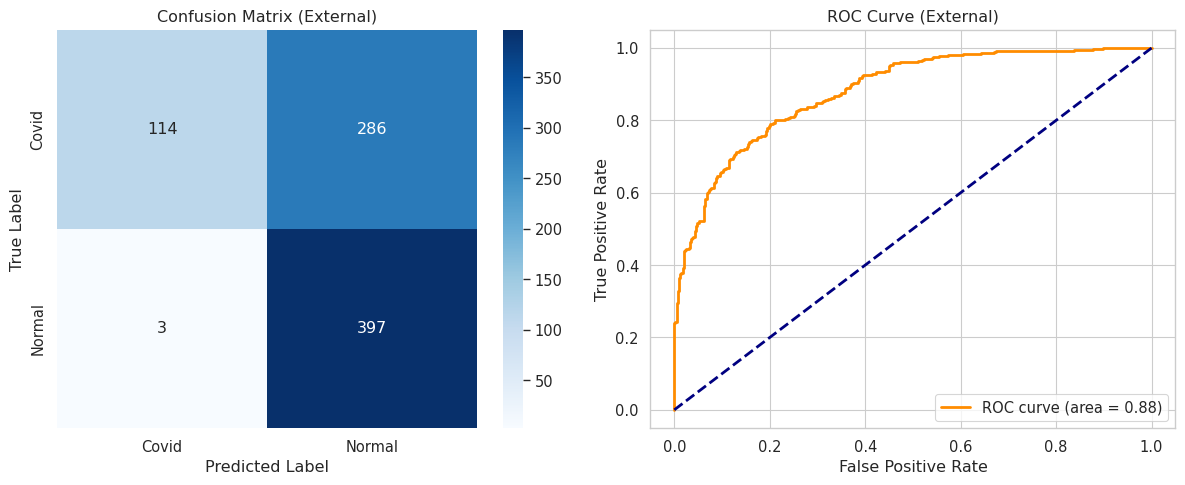

In [39]:
evaluate_external_dataset(dataset_path=path+"/Covid_X-Ray_Dataset",model=model,device=config.device,config=config)

In [42]:
path = kagglehub.dataset_download("alsaniipe/chest-x-ray-image")
print("Path to dataset files:", path)
!rm -rf {path}/Data/test/PNEUMONIA
!ls {path}/Data/test

Path to dataset files: /root/.cache/kagglehub/datasets/alsaniipe/chest-x-ray-image/versions/1


Loading external dataset from /root/.cache/kagglehub/datasets/alsaniipe/chest-x-ray-image/versions/1/Data/test...
Evaluating on 433 images found in /root/.cache/kagglehub/datasets/alsaniipe/chest-x-ray-image/versions/1/Data/test...
External Evaluation Results:
Loss: 0.3412
Accuracy: 0.8614


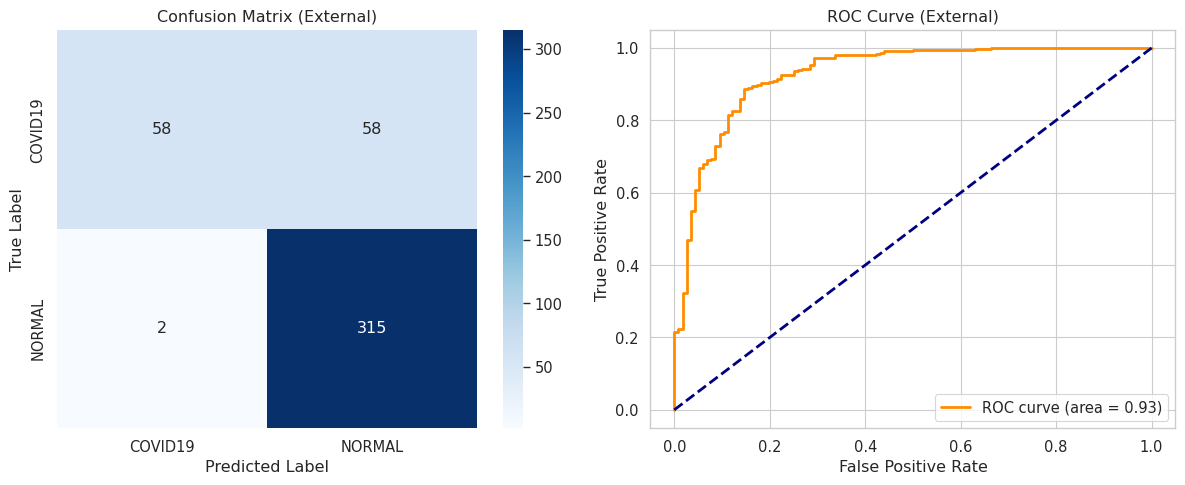

In [48]:
evaluate_external_dataset(dataset_path=path+"/Data/test",model=model,device=config.device,config=config)

In [49]:
path = kagglehub.dataset_download("fozlerabbi/covid19")
print("Path to dataset files:", path)
!ls {path}/CovidDataset/Val

100%|██████████| 133M/133M [00:07<00:00, 19.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fozlerabbi/covid19/versions/1


Loading external dataset from /root/.cache/kagglehub/datasets/fozlerabbi/covid19/versions/1/CovidDataset/Val...
Evaluating on 60 images found in /root/.cache/kagglehub/datasets/fozlerabbi/covid19/versions/1/CovidDataset/Val...
External Evaluation Results:
Loss: 0.8642
Accuracy: 0.6833


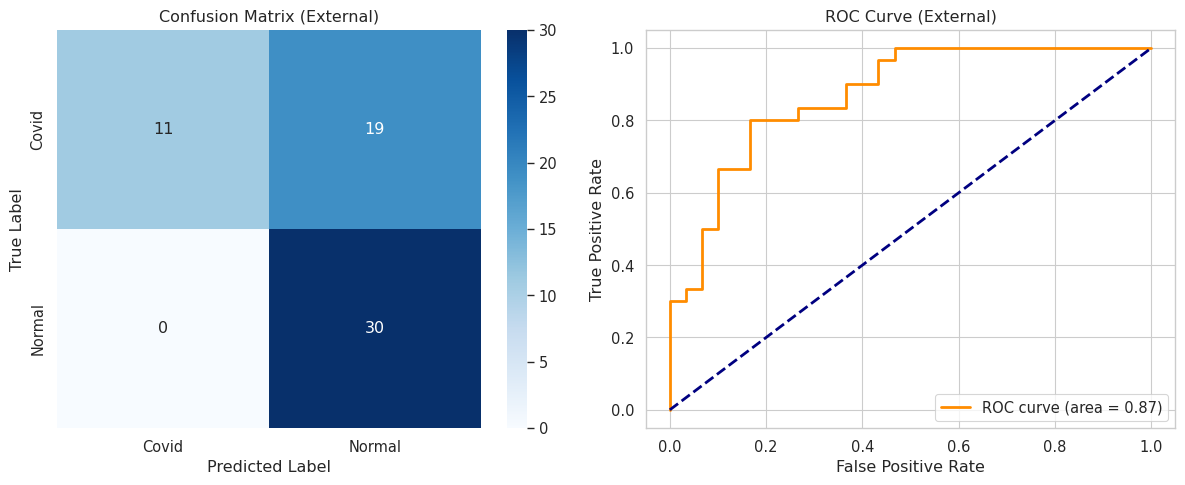

In [54]:
evaluate_external_dataset(dataset_path=path+"/CovidDataset/Val",model=model,device=config.device,config=config)

In [60]:
path = kagglehub.dataset_download("iskorpittt/covid-x-ray-images-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'covid-x-ray-images-dataset' dataset.
Path to dataset files: /kaggle/input/covid-x-ray-images-dataset
rm: cannot remove '/kaggle/input/covid-x-ray-images-dataset/covid_dataset/viral_pneumonia/Viral Pneumonia-1310.png': Read-only file system
rm: cannot remove '/kaggle/input/covid-x-ray-images-dataset/covid_dataset/viral_pneumonia/Viral Pneumonia-1144.png': Read-only file system
rm: cannot remove '/kaggle/input/covid-x-ray-images-dataset/covid_dataset/viral_pneumonia/Viral Pneumonia-1022.png': Read-only file system
rm: cannot remove '/kaggle/input/covid-x-ray-images-dataset/covid_dataset/viral_pneumonia/Viral Pneumonia-740.png': Read-only file system
rm: cannot remove '/kaggle/input/covid-x-ray-images-dataset/covid_dataset/viral_pneumonia/Viral Pneumonia-199.png': Read-only file system
rm: cannot remove '/kaggle/input/covid-x-ray-images-dataset/covid_dataset/viral_pneumonia/Viral Pneumonia-526.png': Read-only file system
rm: cannot remove '/kagg

Creating temporary directory for evaluation at: ./temp_covid_dataset_for_evaluation
Copying '/kaggle/input/covid-x-ray-images-dataset/covid_dataset/covid' to './temp_covid_dataset_for_evaluation/covid'...
Copy complete.
Copying '/kaggle/input/covid-x-ray-images-dataset/covid_dataset/normal' to './temp_covid_dataset_for_evaluation/normal'...
Copy complete.

Starting evaluation on the prepared dataset...
Loading external dataset from ./temp_covid_dataset_for_evaluation...
Evaluating on 13808 images found in ./temp_covid_dataset_for_evaluation...
External Evaluation Results:
Loss: 0.4593
Accuracy: 0.8378


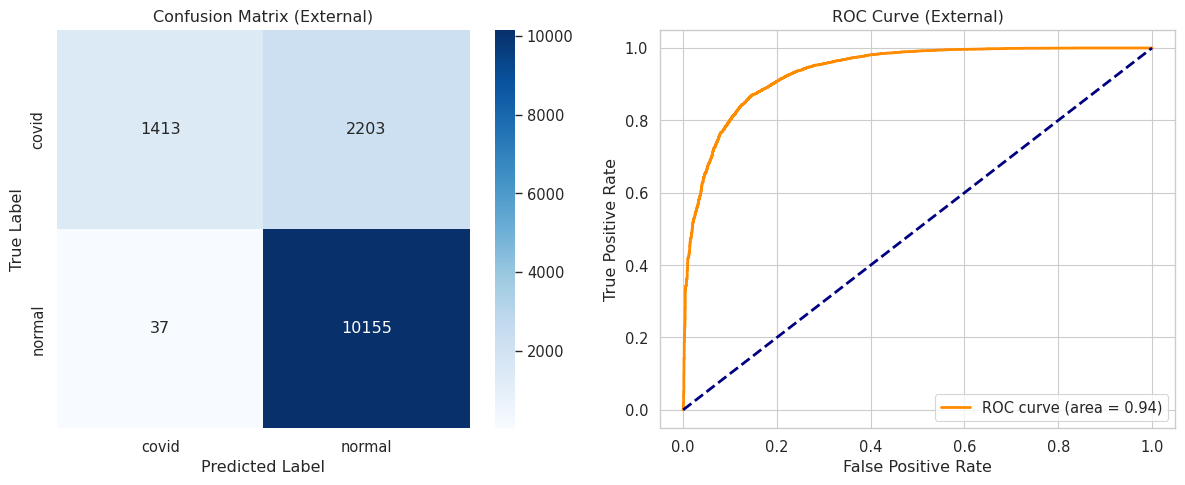

In [61]:
# Original path from kagglehub (from the previous cell)
kaggle_path_covid_xray = path + "/covid_dataset"
temp_path_for_evaluation = "./temp_covid_dataset_for_evaluation"

print(f"Creating temporary directory for evaluation at: {temp_path_for_evaluation}")
os.makedirs(temp_path_for_evaluation, exist_ok=True)

# Define source directories to copy (assuming 'covid' and 'normal' are the desired classes)
source_covid_dir = os.path.join(kaggle_path_covid_xray, "covid")
source_normal_dir = os.path.join(kaggle_path_covid_xray, "normal")

# Define destination directories within the temporary path
dest_covid_dir = os.path.join(temp_path_for_evaluation, "covid")
dest_normal_dir = os.path.join(temp_path_for_evaluation, "normal")

# Copy only 'covid' and 'normal' folders to the temporary directory
# Use shutil.copytree with dirs_exist_ok=True to handle cases where directories might partially exist

if os.path.exists(source_covid_dir):
    print(f"Copying '{source_covid_dir}' to '{dest_covid_dir}'...")
    shutil.copytree(source_covid_dir, dest_covid_dir, dirs_exist_ok=True)
    print("Copy complete.")
else:
    print(f"Warning: '{source_covid_dir}' not found in the dataset.")

if os.path.exists(source_normal_dir):
    print(f"Copying '{source_normal_dir}' to '{dest_normal_dir}'...")
    shutil.copytree(source_normal_dir, dest_normal_dir, dirs_exist_ok=True)
    print("Copy complete.")
else:
    print(f"Warning: '{source_normal_dir}' not found in the dataset.")

# Now, evaluate the model using the dataset in the temporary path
print("\nStarting evaluation on the prepared dataset...")
evaluate_external_dataset(dataset_path=temp_path_for_evaluation, model=model, device=config.device, config=config)

# Optional: Clean up the temporary directory after evaluation
print(f"\nCleaning up temporary directory: {temp_path_for_evaluation}")
shutil.rmtree(temp_path_for_evaluation)


In [64]:
path = kagglehub.dataset_download("muhammadshahbazkhan/covid19-pakistani-patients-xray-image-dataset")
print("Path to dataset files:", path)
!ls {path}/LOCALDATA

Using Colab cache for faster access to the 'covid19-pakistani-patients-xray-image-dataset' dataset.
Path to dataset files: /kaggle/input/covid19-pakistani-patients-xray-image-dataset
COVID  NORMAL


Loading external dataset from /kaggle/input/covid19-pakistani-patients-xray-image-dataset/LOCALDATA...
Evaluating on 450 images found in /kaggle/input/covid19-pakistani-patients-xray-image-dataset/LOCALDATA...
External Evaluation Results:
Loss: 2.9597
Accuracy: 0.1733


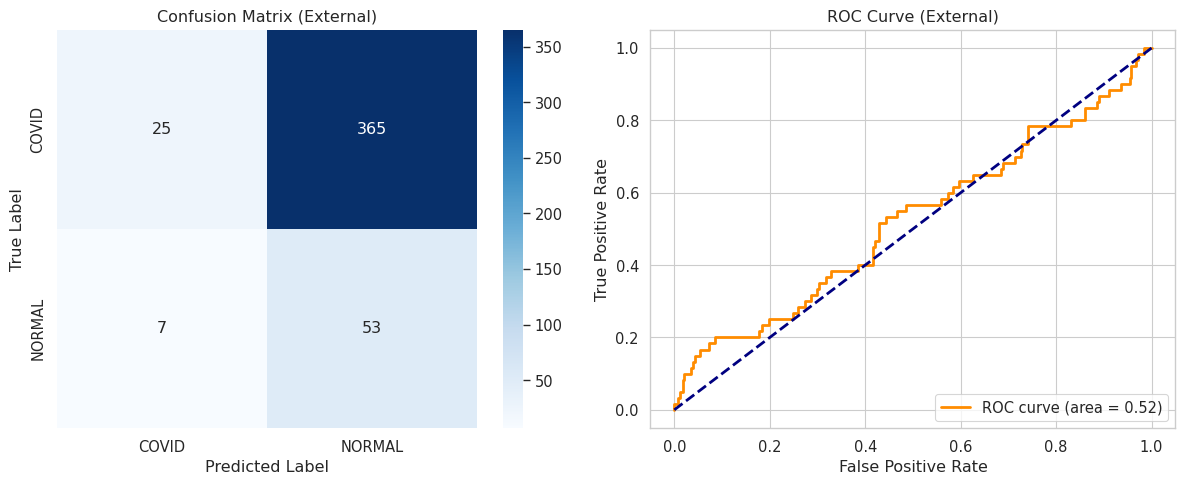

In [65]:
evaluate_external_dataset(dataset_path=path+"/LOCALDATA",model=model,device=config.device,config=config)